# Redes Neurais Recorrentes (RNNs)

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- RNNs;
- LSTM.

## 

# Introdução

Até agora, nós vimos diversos tipos de redes neurais, e elas podem ser utilizadas para diversos problemas. A partir de entradas, elas calculavam uma saída como previsão. 

Porém, um tipo de dados comuns de se trabalhar são os __sequenciais__, como séries temporais e textos.

<div>
<img src="https://www.tradingview.com/x/BIMmjLxL/" width=600 align="center"/>
</div>

<div>
<img src="attachment:image.png" width=600 align="center"/>
</div>

Nesse tipo de dados, os valores "passados" tem forte relação com os valores "futuros", algo que não está explícito nas arquiteturas que vimos até aqui. Para tentar explicitar isso, vamos usar __redes neurais recorrentes__.

## 

# Redes Neurais Recorrentes (RNNs)

Nas __redes neurais recorrentes__, a saída de uma camada escondida também funciona como a entrada dessa mesma camada escondida! 

<div>
<img src = "https://www.deeplearningbook.com.br/wp-content/uploads/2019/07/rnn.png" width=600>
<div>

Mas como funciona isso? Imagina que a saída em um dado passo de tempo é a entrada no passo de tempo seguinte.
<br><br>
<div>
<img src="https://www.deeplearningbook.com.br/wp-content/uploads/2019/08/RNN-unrolled-1024x269.png" width=600>
</div>

Pode-se entender a rede neural recorrente como uma combinação de redes neurais em sequência, dessa forma as previsões levam em considerar o que foi passado anteriormente. As RNNs mais tradicionais podem apresentar um problema de dependência ao longo prazo, ou seja o intervalo de dados anteriores que seja preciso para fazer as próximas predições seria muito grandes, o que inviabiliza o desenvolvimento da RNN.

<br>

Uma forma de evitar este tipo de problema seria justamente utlizar de RNNs que tenha a capacidade de armazenamento de memória, garantindo que seja repassado dependências de longo prazo, uma dessas redes é a __Long Short Time Memory (LSTM).__

<img src="https://miro.medium.com/max/875/0*z_7CtCBqX5OycQx4.png" width = 600>

Não vamos entrar no detalhe de como a LSTM faz esse armazenamento de fato, mas para mais detalhes, têm este [artigo](https://medium.com/@web2ajax/redes-neurais-recorrentes-lstm-b90b720dc3f6) do _Medium_ detalhando todo o processo.

A seguir vamos ver ,um exemplo de aplicação utlizando a _LSTM_ em NLP e em Séries Temporais.

## 

### Exemplo aplicado a NLP

Utilizando a base de dados sobre notificações de desastres pelo _Twitter_ `tweet.csv` e vamos desenvolver os seguintes tópicos abaixo:

__A)__ Crie uma função para fazer o preprocessing da base `tweet.csv` e uma função para aplicar o TF-IDF;

__B)__ Crie uma função que teste diversos modelos de Classificação como por exemplo: Regressão Logística, Árvore de Decisão, RandomForest e AdaBoost. Além disso, para cada modelo plote as principais métricas e por fim plote uma curva ROC-AUC. Teste os Modelos

__C)__ Desenvolva uma Rede Neural Embedding com LSTM para fazer a classificação dos tweets. Qual a rede neural teve uma performance melhor que o modelo tradicional?


### Resolução:

In [ ]:
# Imports utilizados em todos os exercícios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libs para NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
import re

# Libs de Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix

# Libs para Redes Neurais
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Import da biblioteca warnings para ignorar eventuais warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sandro.saorin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sandro.saorin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\sandro.saorin\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


__A)__ Crie uma função para fazer o preprocessing da base `tweet.csv` e uma função para aplicar o TF-IDF;

In [ ]:
# Carrega a base de dados
tweets = pd.read_csv('tweets.csv')

In [ ]:
# Print dos primeiros resultados
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Olhar o balanço das classes
tweets['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Define os stopwords
stopwords = set(stopwords.words('english'))

# Define o Stemming
stemmer = PorterStemmer()

# Pipeline - Text Preprocessing
def preprocessing(string):
    ###
    # Remove Numbers
    string = re.sub(r'\d', '', string)
    ###
    # Remove Special Characters
    string = re.sub(r"[^a-zA-Z0-9]+", ' ', string)
    ###
    # Lowercase words
    string = string.lower()
    ###
    # Word Tokenize
    words = word_tokenize(string)
    ###
    # Remove Stopwords
    filtered_words = []
    for w in words:
        if w not in stopwords:
            filtered_words.append(w)
    ###
    # Stemming Words
    stem_words = []
    for w in filtered_words:
        s_words = stemmer.stem(w)
        stem_words.append(s_words)
    ###
    return stem_words

In [ ]:
# APlica o preprocessing para os texts
tweets["filtered_words"] = tweets['text'].apply(lambda x: preprocessing(x))

# Une novamente as palavras, agora ja filtradas
tweets['join_words'] = tweets['filtered_words'].apply(lambda x: ' '.join(x))

In [ ]:
# Print das Primeiras linhas
tweets.head()

,id,keyword,location,text,target,filtered_words,join_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, earthquak, may, allah, forgiv, us]",deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, rong, sask, canada]",forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[resid, ask, shelter, place, notifi, offic, ev...",resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[peopl, receiv, wildfir, evacu, order, califor...",peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, rubi, alaska, smoke, wildfi...",got sent photo rubi alaska smoke wildfir pour ...


In [ ]:
# Instancia o TF IDF
tfidf = TfidfVectorizer(use_idf = True)

In [ ]:
# Função para transformar os dados pelo TF IDF
def TF_IDF_fit_transform(X_to_fit_and_transform, X_to_transform):
    X_fit_transformed = tfidf.fit_transform(X_to_fit_and_transform)
    X_transformed     = tfidf.transform(X_to_transform)
    return X_fit_transformed.todense(), X_transformed.todense()

__B)__ Crie uma função que teste diversos modelos de Classificação como por exemplo: Regressão Logística, Árvore de Decisão, RandomForest e AdaBoost. Além disso, para cada modelo plote as principais métricas e por fim plote uma curva ROC-AUC. Teste os Modelos

In [ ]:
# Função para testar varios modelos e devolver um plot da curva ROC e principais métricas
def test_models_plot_roc_auc_curve(model_list, col_model_name, col_model, X_train, X_test, y_train, y_test):
    for mdl in model_list:
        model = mdl[col_model]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc = metrics.roc_auc_score(y_test, model.predict(X_test))
        plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (mdl[col_model_name], auc))
        print("Model      : %s" % mdl[col_model_name])
        print("Accuracy   : %0.4f " %  accuracy_score(y_test, y_predict))
        print("Precision  : %0.4f " % precision_score(y_test, y_predict, average='weighted'))
        print("Recall     : %0.4f " % recall_score(y_test, y_predict, average='weighted'))
        print("F1 - Score : %0.4f " % f1_score(y_test, y_predict, average='weighted'))
        print("ROC - AUC  : %0.4f " % auc)
        print("======================")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Define uma seed aleatória
random_seed = 42

# Define uma lista de modelos a serem testados
list_models = [
{'model_name': 'Logistic Regression',
 'estimator' : LogisticRegression(random_state = random_seed, 
                                  solver = 'lbfgs')},
{'model_name': 'Decision Tree',
 'estimator' : DecisionTreeClassifier(random_state = random_seed)},
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed)}, 
{'model_name': 'AdaBoost',
 'estimator' : AdaBoostClassifier(random_state = random_seed)}
]

In [ ]:
# Separação entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(tweets['join_words'], 
                                                     tweets['target'], 
                                                     test_size = 0.3, 
                                                     random_state = random_seed,
                                                     stratify = tweets['target'])

Model      : Logistic Regression
Accuracy   : 0.7964 
Precision  : 0.7965 
Recall     : 0.7964 
F1 - Score : 0.7944 
ROC - AUC  : 0.7852 
Model      : Decision Tree
Accuracy   : 0.7320 
Precision  : 0.7312 
Recall     : 0.7320 
F1 - Score : 0.7315 
ROC - AUC  : 0.7249 
Model      : Random Forest
Accuracy   : 0.7986 
Precision  : 0.8047 
Recall     : 0.7986 
F1 - Score : 0.7938 
ROC - AUC  : 0.7808 
Model      : AdaBoost
Accuracy   : 0.7583 
Precision  : 0.7678 
Recall     : 0.7583 
F1 - Score : 0.7495 
ROC - AUC  : 0.7352 


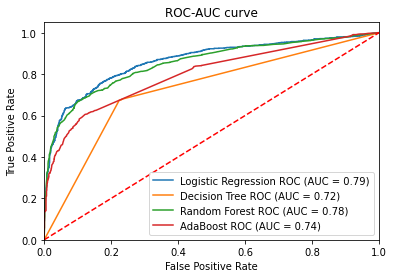

In [ ]:
# Aplica a transformação TF-IDF
X_train_tfidf, X_test_tfidf = TF_IDF_fit_transform(X_train, X_test)

# Aplica a função que testa varios modelos
test_models_plot_roc_auc_curve(list_models,
                              "model_name",
                              "estimator",
                              X_train_tfidf,
                              X_test_tfidf,
                              y_train,
                              y_test)

__C)__ Desenvolva uma Rede Neural Embedding com LSTM para fazer a classificação dos tweets. Qual a rede neural teve uma performance melhor que o modelo tradicional?

In [ ]:
# Função para contar palavras
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [ ]:
# Define o texto
text = tweets['join_words']

# Contagem de todas as palavras
counter = counter_word(text)

In [ ]:
# Quantidade total de palavras
len(counter)

17692

In [ ]:
# Define o num_words
num_words = len(counter)

# Define o maximo de caracteres num tweet
max_len = 157

In [ ]:
# aplica o Tokenizer na base de treino
tokenizer = Tokenizer(num_words = num_words)

# Fit nos textos
tokenizer.fit_on_texts(X_train)

In [ ]:
# Converte os textos em palavras em sequencia
X_train = tokenizer.texts_to_sequences(X_train)

# Separa as sequencias em pedaços
train_padded = pad_sequences(X_train, maxlen = max_len, truncating = "post")

In [ ]:
# Converte os textos em palavras em sequencia
X_test = tokenizer.texts_to_sequences(X_test)

# Separa as sequencias em pedaços
test_padded = pad_sequences(X_test, maxlen = max_len, truncating = "post")

In [ ]:
# Define um callback de early Stopping
callbacks  = [EarlyStopping(monitor = 'val_loss',
                            min_delta = 0,
                            patience = 5,
                            mode = 'auto')]

In [ ]:
# Monta a arquitetura de Embedding com LSTM
model = Sequential([
            Embedding(num_words, 
                      32, 
                      input_length = max_len),
            LSTM(64, dropout = 0.2),
            Dense(1, activation = 'sigmoid')])

In [ ]:
# Sumário da rede
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 157, 32)           566144    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 591,041
Trainable params: 591,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilador da rede
model.compile(optimizer = "Adam", 
              loss = "binary_crossentropy", 
              metrics = ["accuracy"])

In [ ]:
# Fit da Rede
history = model.fit(train_padded, 
                    y_train, 
                    epochs = 30, 
                    validation_data = (test_padded, y_test), 
                    callbacks = callbacks)

Epoch 1/30
167/167 [==============================] - 13s 68ms/step - loss: 0.6045 - accuracy: 0.6735 - val_loss: 0.4589 - val_accuracy: 0.7898
Epoch 2/30
167/167 [==============================] - 11s 68ms/step - loss: 0.3441 - accuracy: 0.8508 - val_loss: 0.4319 - val_accuracy: 0.8139
Epoch 3/30
167/167 [==============================] - 11s 66ms/step - loss: 0.2020 - accuracy: 0.9274 - val_loss: 0.5022 - val_accuracy: 0.8069
Epoch 4/30
167/167 [==============================] - 11s 68ms/step - loss: 0.1145 - accuracy: 0.9593 - val_loss: 0.5778 - val_accuracy: 0.7763
Epoch 5/30
167/167 [==============================] - 11s 67ms/step - loss: 0.0690 - accuracy: 0.9765 - val_loss: 0.6584 - val_accuracy: 0.7842
Epoch 6/30
167/167 [==============================] - 11s 67ms/step - loss: 0.0492 - accuracy: 0.9850 - val_loss: 0.6862 - val_accuracy: 0.7653
Epoch 7/30
167/167 [==============================] - 12s 70ms/step - loss: 0.0403 - accuracy: 0.9906 - val_loss: 0.7786 - val_accuracy:

In [ ]:
# Define as predições para a base de teste
y_pred = np.where(model.predict(test_padded) >= 0.5, 1, 0)
y_pred

array([[1],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
# Print do Classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1303
           1       0.73      0.74      0.74       981

    accuracy                           0.77      2284
   macro avg       0.77      0.77      0.77      2284
weighted avg       0.77      0.77      0.77      2284



Resultado para o Embedding com LSTM ficou bem próximo do resultado obtido para a melhor combinação de modelo com o TF-IDF, mostrando o potencial de desenvolvimento de uma rede neural.

## 

### Exemplo aplicado a Séries Temporais

Use a base de dados `covid_saopaulo.csv` para desenvolver uma rede dinâmica LSTM e faça predições das mortes usando um trecho da série temporal de 21 dias.

### Resolução:

In [ ]:
# carrega a base de dados
covidsp = pd.read_csv('covid_saopaulo.csv', index_col = 'date', parse_dates = True)

In [ ]:
# Dropa a coluna de casos confirmados
covidsp = covidsp.drop('confirmed', axis = 1)

In [ ]:
# ajusta os indices como um date_range
idx = pd.date_range(start = covidsp.index.min(), end = covidsp.index.max(), freq = 'D')

In [ ]:
# Altera os indices
covidsp = covidsp.reindex(idx)

In [ ]:
# Preenche os nulos com 0
covidsp.fillna(0, inplace = True)

In [ ]:
# Print das primeiras linhas
covidsp.head()

,deaths
2020-02-26,0.0
2020-02-27,0.0
2020-02-28,0.0
2020-02-29,0.0
2020-03-01,0.0


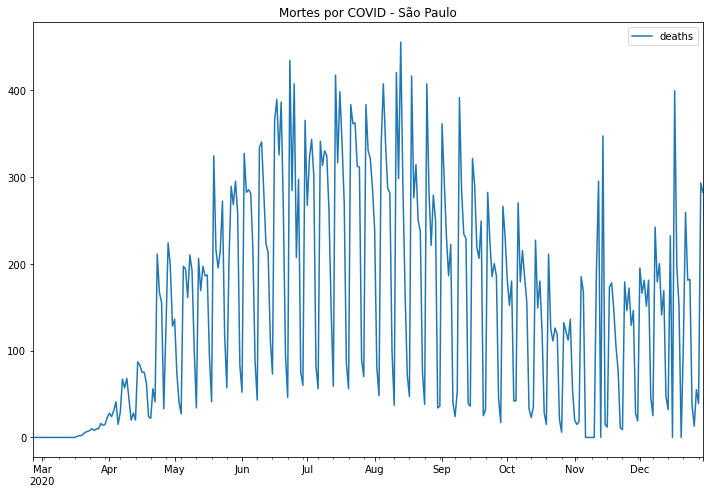

In [ ]:
# Plot da serie temporal
covidsp.plot(figsize=(12,8))

# Cria um titulo
plt.title('Mortes por COVID - São Paulo')

# Mostra o gráfico
plt.show()

In [ ]:
# Determina o tamanho total menos os 21 dias de teste
len(covidsp)-21

288

In [ ]:
# Separa os dados em treino e teste
train = covidsp.iloc[:288]
test = covidsp.iloc[288:]

In [ ]:
# Dimensões das bases de treino e teste
train.shape, test.shape

((288, 1), (21, 1))

In [ ]:
# import do Scaler
from sklearn.preprocessing import MinMaxScaler

# Define a normalização
scaler = MinMaxScaler()

In [ ]:
# Aplica a normalização dos dados
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Definindo os tamanhos dos lotes de treinamento
n_input = 7
n_features = 1

# Definindo o generator para a serie temporal
generator = TimeseriesGenerator(scaled_train, 
                                scaled_train, 
                                length = n_input, 
                                batch_size = 2)

In [ ]:
# Testando o primeiro Lote
X, y = generator[0]

In [ ]:
# Entendendo a separação em lotes e a previsão esperada
print('Dados Esperados por lote e previsão')
print(f'Primeiro Lote: \n{X.flatten()}');
print(f'Previsão: \n {y}');

Dados Esperados por lote e previsão
Primeiro Lote: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Previsão: 
 [[0.]
 [0.]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
# Defina o modelo
model = Sequential([
            LSTM(100, activation='relu', input_shape=(n_input, n_features)),
            Dense(1, activation = 'sigmoid')])

In [ ]:
# Sumario da Rede
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilador do modelo
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit do modelo
model.fit(generator, epochs=250)

Epoch 1/250
141/141 [==============================] - 1s 3ms/step - loss: 0.0824
Epoch 2/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0413
Epoch 3/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0344
Epoch 4/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0315A: 0s - loss: 0
Epoch 5/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0261
Epoch 6/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 7/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 8/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0224
Epoch 9/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 10/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 11/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 12/250
141/141 [==============================] - 0s 3ms/step - loss: 0.018

141/141 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 194/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 195/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 196/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 197/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0071A: 0s - loss: 0.0
Epoch 198/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 199/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 200/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0075A: 0s - loss: 0.00
Epoch 201/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 202/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0071A: 0s - loss: 0.00
Epoch 203/250
141/141 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 204/250
141/141 [==============

In [ ]:
# Considerando as previsões para as próximas 21 observações e comparar com a base de teste

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
# Predições do modelo
test_predictions

[array([0.3782466], dtype=float32),
 array([0.38265842], dtype=float32),
 array([0.37322038], dtype=float32),
 array([0.11293504], dtype=float32),
 array([0.09089309], dtype=float32),
 array([0.45345584], dtype=float32),
 array([0.46304548], dtype=float32),
 array([0.42782748], dtype=float32),
 array([0.46145132], dtype=float32),
 array([0.4072778], dtype=float32),
 array([0.14901853], dtype=float32),
 array([0.10463712], dtype=float32),
 array([0.5528399], dtype=float32),
 array([0.5550343], dtype=float32),
 array([0.47290614], dtype=float32),
 array([0.49813247], dtype=float32),
 array([0.54370254], dtype=float32),
 array([0.207162], dtype=float32),
 array([0.08193004], dtype=float32),
 array([0.62791723], dtype=float32),
 array([0.6034088], dtype=float32)]

In [ ]:
# Revertendo a normalização
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
# Predições do modelo para 21 dias
true_predictions

array([[172.10220546],
       [174.10958201],
       [169.81527478],
       [ 51.38544157],
       [ 41.35635585],
       [206.32240519],
       [210.68569243],
       [194.66150224],
       [209.96035144],
       [185.31139567],
       [ 67.80342937],
       [ 47.60988787],
       [251.54214323],
       [252.54059732],
       [215.17229483],
       [226.65027261],
       [247.38465697],
       [ 94.25870672],
       [ 37.2781688 ],
       [285.70233971],
       [274.55101013]])

In [ ]:
# Salvando as predições junto a base teste
test['Predictions'] = true_predictions

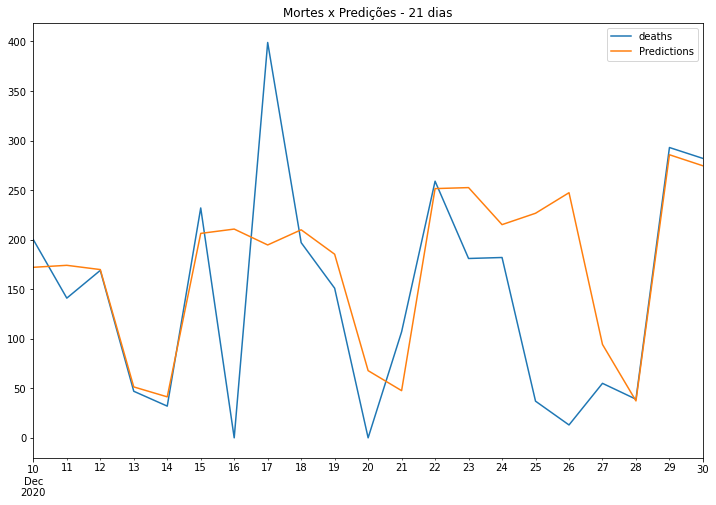

In [ ]:
# Plot da serie temporal
test.plot(figsize=(12,8))

# Cria um titulo
plt.title('Mortes x Predições - 21 dias')

# Mostra o gráfico
plt.show()

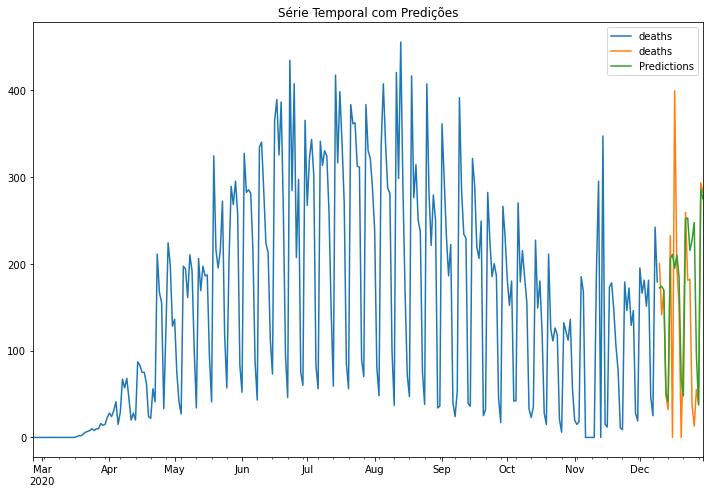

In [ ]:
# Define o tamanho do gráfico e o plot para a base treino
ax = train.plot(figsize=(12,8))

# cria o plot
test.plot(ax=ax)

# Cria um titulo
plt.title('Série Temporal com Predições')

# Mostra o gráfico
plt.show()

## 

## Exercícios

In [ ]:
__1)__ Replique o exercício dos casos de COVID em São Paulo para

## 